In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'detectron2' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.4 MB/s eta 0:00:00


In [4]:
import os 
import pickle
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import torch, torchvision

# import some common detectron2 utilities
from detectron2.data.datasets import register_coco_instances   # For registering the dataset with detectron2
from detectron2.engine import DefaultTrainer,DefaultPredictor # Needed to train the custoum instance segmentation and object detection
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer


In [5]:
import logging
from detectron2.data.datasets import register_coco_instances  # For registering the dataset with detectron2

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import LazyConfig, instantiate
from detectron2.engine import (
    AMPTrainer,
    SimpleTrainer,
    default_argument_parser,
    default_setup,
    default_writers,
    hooks,
    launch,
)
from detectron2.engine.defaults import create_ddp_model
from detectron2.evaluation import inference_on_dataset, print_csv_format
from detectron2.utils import comm


In [6]:
!wget https://dl.fbaipublicfiles.com/detectron2/MViTv2/cascade_mask_rcnn_mvitv2_b_in12k_3x/f309003202/model_final_be5168.pkl

--2023-01-29 20:17:19--  https://dl.fbaipublicfiles.com/detectron2/MViTv2/cascade_mask_rcnn_mvitv2_b_in12k_3x/f309003202/model_final_be5168.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412707456 (394M) [binary/octet-stream]
Saving to: ‘model_final_be5168.pkl’

model_final_be5168. 100%[===================>] 393.59M  14.6MB/s    in 27s     

2023-01-29 20:17:47 (14.4 MB/s) - ‘model_final_be5168.pkl’ saved [412707456/412707456]



In [7]:
#Define the paths to our configration files and our pretrained model files for semantic segmentation
#https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md

config_file_path = r"/content/detectron2/projects/MViTv2/configs/cascade_mask_rcnn_mvitv2_b_in21k_3x.py"#r"cascade_mask_rcnn_mvitv2_b_in21k_3x.py" # Define Model path
checkpoint_url = r"/content/model_final_be5168.pkl"   # Modify this path in the Yaml fine by opening as a text file and paste it
Output_dir = r"/content/output"                              # Define the output of the model 
num_class= 1     # Define the number of classes
device= "cuda" #"cpu"

Training_dataset_name= "Palm_Training2"
Training_images_path = r"/content/Training"         #Define image folder of  training dataset
Training_json_annot = r"/content/Training/trainval.json"    #Define the location of the annotation json file of the training dataset 


Validation_dataset_name= "Palm_Validation2"
Validation_images_path = r"/content/Validation"        #Define image folder of  testing datset
Validation_json_annot = r"/content/Validation/trainval.json"   #Define the location of the annotation json file of testing dataset



Testing_dataset_name= "Palm_Testing"
Testing_images_path = r"/content/Testing"        #Define image folder of  testing datset
Testing_json_annot = r"/content/Testing/trainval.json"   #Define the location of the annotation json file of testing dataset



cfg_save_path = r"/content/output"

In [8]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
cfg = LazyConfig.load(config_file_path)

In [9]:
# set trianing dataset (Registering the training dataset)

register_coco_instances(name=Training_dataset_name, metadata={}, 
                        json_file=Training_json_annot
                        , image_root= Training_images_path)



# set Validation dataset (Registering the validation dataset)

register_coco_instances(name=Validation_dataset_name, metadata={}, 
                        json_file=Validation_json_annot
                        , image_root= Validation_images_path)

# set testing dataset (Registering the testing dataset)


register_coco_instances(name=Testing_dataset_name, metadata={}, 
                        json_file=Testing_json_annot
                        , image_root= Testing_images_path)

In [10]:
import random
from cv2 import *
import skimage.io as io
import matplotlib.pyplot as plt
    
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer,ColorMode
from detectron2.config import get_cfg

# A fucntion takes the dataset and how many images needed to plot

def plot_samples(dataset_name, n=9): #
        fig, ax = plt.subplots(3, 3, figsize =(16,16))
        indices=[ax[0][0],ax[1][0],ax[2][0],ax[0][1],ax[1][1],ax[2][1],ax[0][2],ax[1][2],ax[2][2] ]
        data_custom= DatasetCatalog.get(dataset_name)
        data_custom_metadata=MetadataCatalog.get(dataset_name) #getting the metadata
        i=-1
        for s in random.sample (data_custom,n):
            i=i+1 
            img= io.imread(s["file_name"])
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            v= Visualizer(img_rgb= img[:,:,::-1], metadata=data_custom_metadata,scale=2)
            v= v.draw_dataset_dict(s)
            indices[i].grid(False)
            indices[i].imshow(v.get_image()[:, :, ::-1])   

WARNING [01/29 20:19:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/29 20:19:39 d2.data.datasets.coco]: Loaded 21 images in COCO format from /content/Training/trainval.json


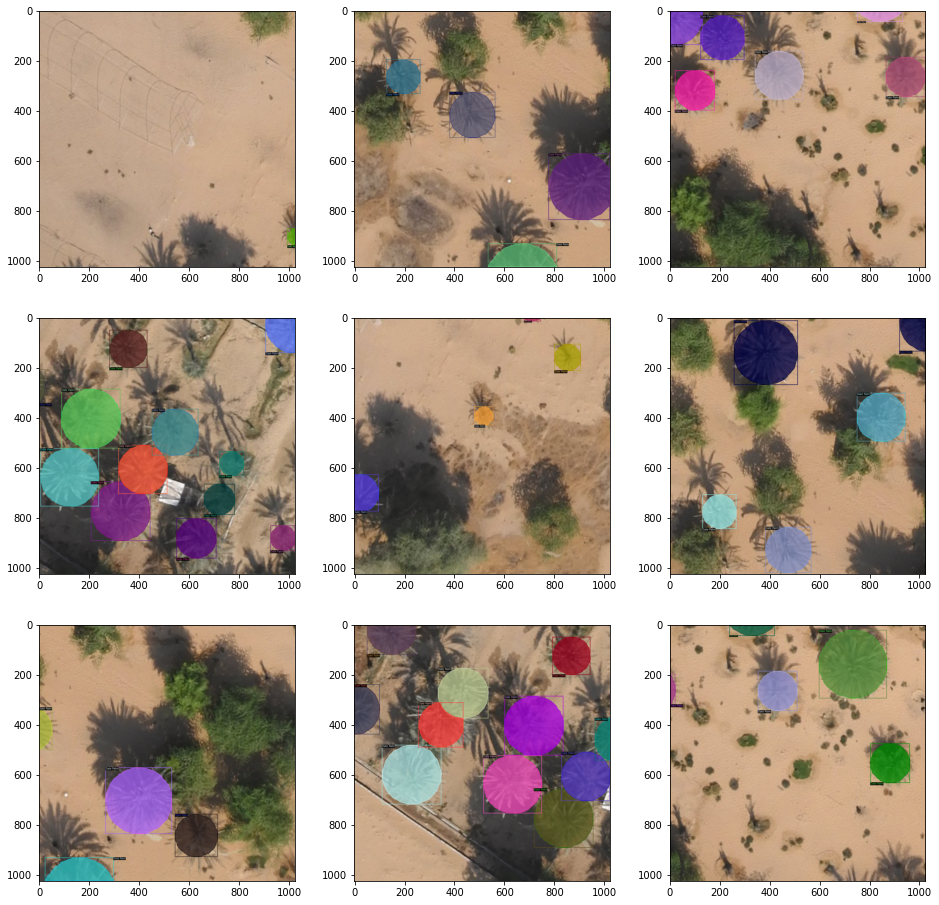

In [12]:
# Visualize some training samples
plot_samples(Training_dataset_name)

# Visualize some training samples


#plot_samples(test_dataset_name)

In [13]:
from detectron2.config import get_cfg
import os
            
def get_train_cfg(config_file_path,checkpoint_url,train_dataset_name,test_dataset_name,num_class, device, Output_dir):
    
    # Config definition
    # -----------------------------------------------------------------------------
    cfg=LazyConfig.load(config_file_path)
    #cfg.MODEL.DEVICE= device    #  Define where do you want to run your model CPU, GPU(s)
#     cfg.merge_from_file(config_file_path) # merge with specific config chosen before
    #cfg.MODEL.WEIGHT= checkpoint_url # Path to a checkpoint file
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
    # INPUT
    # -----------------------------------------------------------------------------
    #By default, {MIN,MAX}_SIZE options are used in transforms.ResizeShortestEdge
    #cfg.INPUT.MIN_SIZE_TRAIN=128 # Size of the smallest side of the image during training
    #cfg.INPUT.MAX_SIZE_TRAIN =512 # Maximum size of the side of the image during training
    #cfg.INPUT.MIN_SIZE_TEST = 128 # Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
    #cfg.INPUT.MAX_SIZE_TEST=512 # Maximum size of the side of the image during testing
    # Mode for flipping images used in data augmentation during training
    #cfg.INPUT.RANDOM_FLIP = "horizontal" # choose one of ["horizontal, "vertical", "none"]
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
    # Dataset
    # -----------------------------------------------------------------------------#
    
    # List of the dataset names for training and testing. Must be registered in DatasetCatalog
    #cfg.DATASETS.TRAIN= (train_dataset_name,) 
    #cfg.DATASETS.TEST= (Validation_dataset_name,)
    
    cfg.dataloader.train.dataset.names= train_dataset_name
    cfg.dataloader.test.dataset.names = test_dataset_name
    
    cfg.train.init_checkpoint = checkpoint_url
    cfg.train.max_iter = 100
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
    # DataLoader
    # -----------------------------------------------------------------------------#
    cfg.dataloader.train.num_workers = 2    # The more workers, the quicker the dataset to be loaded
    cfg.dataloader.train.total_batch_size = 1
    cfg.model.roi_heads.batch_size_per_image = 64
    # Tf True, when working on datasets that have instance annotations, the training dataloader will filter out images without associated annotations
    #cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
    # Anchor generator options
    #cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[4,8,16,32,64]]
    #cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32, 64, 128, 256, 512]]

    #ASPECT_RATIOS[i] specifies the list of aspect ratios (H/W)
    #cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0]]
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
    # RPN options
    # ---------------------------------------------------------------------------- #  
    
    # Maximum overlap allowed between an anchor and ground-truth box for the (anchor, gt box) pair to be 
    #a negative examples (IoU < BG_IOU_THRESHOLD ==> negative RPN example: 0)
    # Anchors with overlap in between (BG_IOU_THRESHOLD <= IoU < FG_IOU_THRESHOLD) are ignored (-1)    
    ####cfg.MODEL.RPN.IOU_THRESHOLDS = [0.3, 0.6]
    #####cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 512     # Number of regions per image used to train RPN
    #cfg.MODEL.RPN.LOSS_WEIGHT = 1.0
    
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
    # ROI HEADS options
    # ---------------------------------------------------------------------------- #
    cfg.model.roi_heads.num_classes = num_class  # Define the no of classes
    #Number of regions per image used to train RPN
    # RoI minibatch size *per image* (number of regions of interest [ROIs]) during training
    #Total number of RoIs per training minibatch = ROI_HEADS.BATCH_SIZE_PER_IMAGE * SOLVER.IMS_PER_BATCH
    cfg.model.roi_heads.batch_size_per_image = 512  #(default: 512) # faster, and good enough for this toy dataset    
    
    # IOU overlap ratios [IOU_THRESHOLD] Overlap threshold for an RoI to be considered background 
    #(if < IOU_THRESHOLD) Overlap threshold for an RoI to be considered foreground (if >= IOU_THRESHOLD)
    #cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.5]
    
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
    # Solver
    # ---------------------------------------------------------------------------- #

    ###cfg.SOLVER.OPTIMIZER = 'SGD'
    ###cfg.SOLVER.MAX_ITER= 100000       # Define the maximum number of iterations
    ###cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR
    ###cfg.SOLVER.GAMMA = 0.5  #The iteration number to decrease learning rate by GAMMA.
    ###cfg.SOLVER.STEP =[]  # Don't decary learning rate
    #cfg.SOLVER.STEPS = (10000,15000,20000,25000,30000 ) # the checkpoints (number of iterations) at which the learning rate will be reduced by GAMMA
    #cfg.SOLVER.MOMENTUM = 0.9
    #cfg.SOLVER.NESTEROV = False
    #cfg.SOLVER.WEIGHT_DECAY = 0.0001
    #cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
    ###cfg.SOLVER.WARMUP_ITERS = 15000  # Warmup iterations to linearly ramp learning rate from zero
    #cfg.SOLVER.WARMUP_METHOD = "linear"
    #Number of images per batch across all machines. This is also the numberof training images per step (i.e. per iteration)
    ####cfg.SOLVER.IMS_PER_BATCH= 8  # No of images per batch   
    ####cfg.SOLVER.CHECKPOINT_PERIOD = 2000  # Small value=Frequent save need a lot of storage.
    
    # Learning rate scheduler
    '''Default build_lr_schduler method (docs) supports only 2 types of LR scheduling, 
    WarmupMultiStepLR (default) & WarmupCosineLR. You can change which one to use by 
    setting cfg.SOLVER.LR_SCHEDULER_NAME as you can see from the docs.'''
    #https://www.kaggle.com/julienbeaulieu/detectron2-wheat-detection-eda-training-eval
    
    #cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupMultiStepLR'
    #cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
    #cfg.SOLVER.BASE_LS = 0.0001
    #cfg.SOLVER.GAMMA = 0.0005  #The iteration number to decrease learning rate by GAMMA.
    #cfg.SOLVER.STEP =[]  # Don't decary learning rate
    #cfg.SOLVER.STEPS = (5000,10000,15000,20000 ) # the checkpoints (number of iterations) at which the learning rate will be reduced by GAMMA
      
    
    # Sample size of smallest side by choice or random selection from range give by
#     cfg.INPUT.MIN_SIZE_TRAIN = (512,)
#     # Maximum size of the side of the image during training
#     cfg.INPUT.MAX_SIZE_TRAIN = 512
#     # Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
#     cfg.INPUT.MIN_SIZE_TEST = 512
    
    # Maximum size of the side of the image during testing    
    #cfg.SOLVER.WARMUP_ITERS = 3000 #the learning rate starts from 0 and goes to the preset one for this number of iterations
    
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
    # Mask Head
    # ---------------------------------------------------------------------------- #
    # Normalization method for the convolution layers.
    # Options: "" (no norm), "GN", "SyncBN".
    #cfg.MODEL.ROI_MASK_HEAD.NORM = "GN"
        
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
    # Specific test options
    # ---------------------------------------------------------------------------- #
    
    # Set to 0 to disable.
    #cfg.TEST.EVAL_PERIOD = 2000
    #cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('train_dataset_name')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch
    
    # Maximum number of detections to return per image during inference (100 is based on the limit established for the COCO dataset)
    # cfg.TEST.DETECTIONS_PER_IMAGE = 100 
    ###cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
        
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
    # Misc options
    # ---------------------------------------------------------------------------- #
    # Directory where output files are written
    cfg.train.output_dir = Output_dir

    # Set seed to negative to fully randomize everything. Set seed to positive to use a fixed seed. Note that a fixed seed increases
    # reproducibility but does not guarantee fully deterministic behavior. Disabling all parallelism further increases reproducibility.
    #####cfg.SEED = -1
    # The period (in terms of steps) for minibatch visualization at train time.
    # Set to 0 to disable.
    ####3cfg.VIS_PERIOD = 1000

  

    return cfg
    

In [14]:
def do_train(cfg):
    """
    Args:
        cfg: an object with the following attributes:
            model: instantiate to a module
            dataloader.{train,test}: instantiate to dataloaders
            dataloader.evaluator: instantiate to evaluator for test set
            optimizer: instantaite to an optimizer
            lr_multiplier: instantiate to a fvcore scheduler
            train: other misc config defined in `configs/common/train.py`, including:
                output_dir (str)
                init_checkpoint (str)
                amp.enabled (bool)
                max_iter (int)
                eval_period, log_period (int)
                device (str)
                checkpointer (dict)
                ddp (dict)
    """
    model = instantiate(cfg.model)
    logger = logging.getLogger("detectron2")
    logger.info("Model:\n{}".format(model))
    model.to(cfg.train.device)

    cfg.optimizer.params.model = model
    optim = instantiate(cfg.optimizer)

    train_loader = instantiate(cfg.dataloader.train)

    model = create_ddp_model(model, **cfg.train.ddp)
    trainer = (AMPTrainer if cfg.train.amp.enabled else SimpleTrainer)(model, train_loader, optim)
    checkpointer = DetectionCheckpointer(
        model,
        cfg.train.output_dir,
        trainer=trainer,
    )
    trainer.register_hooks(
        [
            hooks.IterationTimer(),
            hooks.LRScheduler(scheduler=instantiate(cfg.lr_multiplier)),
            hooks.PeriodicCheckpointer(checkpointer, **cfg.train.checkpointer)
            if comm.is_main_process()
            else None,
            hooks.EvalHook(cfg.train.eval_period, lambda: do_test(cfg, model)),
            hooks.PeriodicWriter(
                default_writers(cfg.train.output_dir, cfg.train.max_iter),
                period=cfg.train.log_period,
            )
            if comm.is_main_process()
            else None,
        ]
    )
    print("hassssssssssssss",checkpointer.has_checkpoint(),trainer.iter)
    checkpointer.resume_or_load(cfg.train.init_checkpoint,resume=False)
    start_iter =  trainer.iter
    trainer.train(start_iter, cfg.train.max_iter)


In [15]:
import gc 
gc.collect()

19861

In [17]:
def do_test(cfg, model):
    if "evaluator" in cfg.dataloader:
        ret = inference_on_dataset(
            model, instantiate(cfg.dataloader.test), instantiate(cfg.dataloader.evaluator)
        )
        print_csv_format(ret)
        return ret

In [18]:
num_class = 1
Output_dir = Output_dir
cfg = get_train_cfg(config_file_path,checkpoint_url,Training_dataset_name,Validation_dataset_name,num_class, device, Output_dir)
    
'''with open(cfg_save_path, 'wb')as f:
    pickle.dump(cfg, f, protocol=picke.HIGHEST_PROTOCOL)'''
 
os.makedirs(cfg.train.output_dir, exist_ok=True)
# trainer = PalmTrainer(cfg) 
do_train(cfg)  
    
# Garbage collect unused files to free up some memory
#gc.collect()

[01/29 20:22:09 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(96, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): MViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, element

roi_heads.box_predictor.0.cls_score.{bias, weight}
roi_heads.box_predictor.1.cls_score.{bias, weight}
roi_heads.box_predictor.2.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/29 20:22:10 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered i

[01/29 20:22:20 d2.utils.events]:  eta: 0:00:41  iter: 19  total_loss: 3.784  loss_cls_stage0: 0.5222  loss_box_reg_stage0: 0.1903  loss_cls_stage1: 0.3972  loss_box_reg_stage1: 0.2886  loss_cls_stage2: 0.3293  loss_box_reg_stage2: 0.2566  loss_mask: 0.6594  loss_rpn_cls: 0.1066  loss_rpn_loc: 0.05819  time: 0.5086  data_time: 0.0124  lr: 0.00016  max_mem: 6992M


/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[01/29 20:22:30 d2.utils.events]:  eta: 0:00:31  iter: 39  total_loss: 2.479  loss_cls_stage0: 0.186  loss_box_reg_stage0: 0.2797  loss_cls_stage1: 0.1565  loss_box_reg_stage1: 0.5765  loss_cls_stage2: 0.1793  loss_box_reg_stage2: 0.5713  loss_mask: 0.4514  loss_rpn_cls: 0.04422  loss_rpn_loc: 0.02346  time: 0.5110  data_time: 0.0036  lr: 0.00016  max_mem: 7080M


/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersect

[01/29 20:22:40 d2.utils.events]:  eta: 0:00:20  iter: 59  total_loss: 2.359  loss_cls_stage0: 0.1207  loss_box_reg_stage0: 0.2925  loss_cls_stage1: 0.1277  loss_box_reg_stage1: 0.6355  loss_cls_stage2: 0.1229  loss_box_reg_stage2: 0.8333  loss_mask: 0.3216  loss_rpn_cls: 0.02244  loss_rpn_loc: 0.05061  time: 0.5091  data_time: 0.0035  lr: 0.00016  max_mem: 7134M


/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersect

[01/29 20:22:50 d2.utils.events]:  eta: 0:00:10  iter: 79  total_loss: 2.158  loss_cls_stage0: 0.1104  loss_box_reg_stage0: 0.2027  loss_cls_stage1: 0.07469  loss_box_reg_stage1: 0.487  loss_cls_stage2: 0.08288  loss_box_reg_stage2: 0.6776  loss_mask: 0.2808  loss_rpn_cls: 0.0333  loss_rpn_loc: 0.01862  time: 0.5062  data_time: 0.0038  lr: 1.6e-05  max_mem: 7134M


/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersect

[01/29 20:23:06 d2.utils.events]:  eta: 0:00:00  iter: 99  total_loss: 2.36  loss_cls_stage0: 0.1212  loss_box_reg_stage0: 0.2727  loss_cls_stage1: 0.0958  loss_box_reg_stage1: 0.6144  loss_cls_stage2: 0.09602  loss_box_reg_stage2: 0.8405  loss_mask: 0.2635  loss_rpn_cls: 0.02379  loss_rpn_loc: 0.04614  time: 0.5116  data_time: 0.0045  lr: 1.6e-06  max_mem: 7380M
[01/29 20:23:06 d2.engine.hooks]: Overall training speed: 98 iterations in 0:00:50 (0.5116 s / it)
[01/29 20:23:06 d2.engine.hooks]: Total training time: 0:00:55 (0:00:05 on hooks)
WARNING [01/29 20:23:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/29 20:23:06 d2.data.datasets.coco]: Loaded 21 images in COCO format from /content/Validation/trainval.json
[01/29 20:23:06 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| Date Palm  | 176          |
|            |              |
[0

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[01/29 20:23:11 d2.evaluation.evaluator]: Inference done 11/21. Dataloading: 0.0011 s/iter. Inference: 0.3903 s/iter. Eval: 0.0056 s/iter. Total: 0.3970 s/iter. ETA=0:00:03
[01/29 20:23:15 d2.evaluation.evaluator]: Total inference time: 0:00:06.554401 (0.409650 s / iter per device, on 1 devices)
[01/29 20:23:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.391698 s / iter per device, on 1 devices)
[01/29 20:23:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/29 20:23:15 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.411
 Average Precision

In [ ]:

anvil.server.connect("server_FPS4H4JV6LL2OEIZMQY4M66E-7VNAX7SHYSCBEHWO")

@anvil.server.callable
def say_hello(name):
  print("Hello from the uplink, %s!" % name)
# anvil.server.wait_forever()


@anvil.server.callable
def calculate_model(sepal_length):
  df1 = pd.read_excel("/content/ss.xlsx")
  content = io.BytesIO()
  df1.to_excel(content, index=False)
  content.seek(0, 0)
  return anvil.BlobMedia(content=content.read(), content_type="application/vnd.ms-excel",name='output.xlsx')
  # csv_media = anvil.BlobMedia("text/plain", df1, name="Report.csv")
  # return 
@anvil.server.callable
def upload_excel_data(file):
  with open("s.csv", "wb") as f:
    f.write(file.get_bytes())
    df = pd.read_csv(f)
    return "ok"
def download_out():
  df1 = pd.read_excel("/content/ss.xlsx")
  content = io.BytesIO()
  df1.to_excel(content, index=False)
  content.seek(0, 0)
  return anvil.BlobMedia(content=content.read(), content_type="application/vnd.ms-excel",name='output.xlsx')
anvil.server.wait_forever()